# Lab 5: Error mitigation with Qiskit Runtime

In this lab, we'll explore a few of the error mitigation options available through Qiskit Runtime. Specifically, we'll define a simple observable and initial state and use the Estimator primitive to measure the expectation value. Using noisy simulations, we'll explore the effect of different error mitigation strategies.

## Setup

We'll define a simple Heisenberg Hamiltonian model to use as an example. We'll also construct a simple state preparation circuit.

In [1]:
#generate a hamiltonian and prepare a state
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp


def heisenberg_hamiltonian(
    length: int, jx: float = 1.0, jy: float = 0.0, jz: float = 0.0
) -> SparsePauliOp:
    terms = []
    for i in range(length - 1):
        if jx:
            terms.append(("XX", [i, i + 1], jx))
        if jy:
            terms.append(("YY", [i, i + 1], jy))
        if jz:
            terms.append(("ZZ", [i, i + 1], jz))
    return SparsePauliOp.from_sparse_list(terms, num_qubits=length)


def state_prep_circuit(num_qubits: int, layers: int = 1) -> QuantumCircuit:
    qubits = QuantumRegister(num_qubits, name="q")
    circuit = QuantumCircuit(qubits)
    circuit.h(qubits)
    for _ in range(layers):
        for i in range(0, num_qubits - 1, 2):
            circuit.cx(qubits[i], qubits[i + 1])
        circuit.ry(0.1, qubits)
        for i in range(1, num_qubits - 1, 2):
            circuit.cx(qubits[i], qubits[i + 1])
        circuit.ry(0.1, qubits)
    return circuit

SparsePauliOp(['IIIXX', 'IIIYY', 'IIXXI', 'IIYYI', 'IXXII', 'IYYII', 'XXIII', 'YYIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


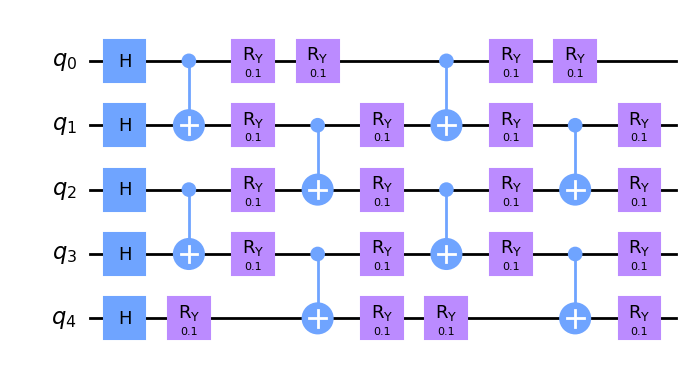

In [2]:
length = 5

hamiltonian = heisenberg_hamiltonian(length, 1.0, 1.0)
circuit = state_prep_circuit(length, layers=2)

print(hamiltonian)
circuit.draw("mpl")

## Calculate exact expectation value (energy)

First, we'll calculate the exact expectation value using a local simulator implementation of the Estimator primitive. The expectation value of a Hamiltonian is also referred to as "energy."

In [3]:
from qiskit_aer.primitives import Estimator

estimator = Estimator(approximation=True)
job = estimator.run(circuit, hamiltonian, shots=None)
result = job.result()
exact_value = result.values[0]

print(f"Exact energy: {exact_value}")
#this is the ground truth number

Exact energy: 4.290938711029713


## Run noisy simulation through Qiskit Runtime

Next, we'll initialize the Qiskit Runtime service and switch to using its Estimator primitive, backed by a simulator that can handle noise. Even though our circuit acts on 5 qubits, we'll initialize a simulator with 6 qubits in order to later demonstrate the potential effects of qubit choice.

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService

hub = "summer-school-1"
group = "group-8"
project = "6758104429"
service = QiskitRuntimeService(instance=f"{hub}/{group}/{project}")

In [6]:
from qiskit_ibm_runtime import Estimator, Options, Session
from qiskit.transpiler import CouplingMap

backend = service.get_backend("simulator_statevector")
# set simulation options
simulator = {
    "basis_gates": ["id", "rz", "sx", "cx", "reset"],
    "coupling_map": list(CouplingMap.from_line(length + 1)),
}
shots = 10000

### No noise

First, we'll run the simulation with no noise.

In [7]:
import math

options = Options(
    simulator=simulator,
    resilience_level=0,
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.2944
Energy error: 0.0034612889702874128
Variance: 4.4450334400000004
Standard error: 0.021083247947126176


### Readout error

Next, let's run a simulation with readout error.

#### Exercise 1

In this exercise, you'll construct a noise model that has modest readout error on all qubits except for the first qubit, which will have really bad readout error.

Specifically, construct a noise model with the following properties:
- For the first qubit (qubit 0):
  - A readout of 1 has a 50% probability of being erroneously read as 0.
  - A readout of 0 has a 20% probability of being erroneously read as 1.
- For the rest of the qubits:
  - A readout of 1 has a 5% probability of being erroneously read as 0.
  - A readout of 0 has a 2% probability of being erroneously read as 1.

You may find it helpful to consult the following resources:
  - https://qiskit.org/ecosystem/aer/apidocs/aer_noise.html
  - https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html

In [10]:
from qiskit_aer.noise import NoiseModel, ReadoutError

noise_model = NoiseModel()

##### your code here #####
qubit0_p0_given1 = 0.2
qubit0_p1_given0 = 0.5
qubit0_p0_given0 = (1 - qubit0_p0_given1)
qubit0_p1_given1 = (1 - qubit0_p1_given0)
qubitk_p0_given1 = 0.02
qubitk_p1_given0 = 0.05
qubitk_p0_given0 = (1 - qubitk_p0_given1)
qubitk_p1_given1 = (1 - qubitk_p1_given0)
readout_error_qubit0 = ReadoutError( [ [ qubit0_p0_given0, qubit0_p0_given1 ],
                                       [ qubit0_p1_given0, qubit0_p1_given1 ] ] )
readout_error_qubitk = ReadoutError( [ [ qubitk_p0_given0, qubitk_p0_given1 ],
                                       [ qubitk_p1_given0, qubitk_p1_given1 ] ] )
noise_model.add_readout_error( readout_error_qubit0, [0] )
for k in range( 1, ( length + 1 ) ):
    noise_model.add_readout_error( readout_error_qubitk, [k] )

print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5]
  Specific qubit errors: [('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,))]


In [11]:
# Submit your answer

from qc_grader.challenges.qgss_2023 import grade_lab5_ex1

grade_lab5_ex1(noise_model)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


First, let's try running the simulation without doing anything to mitigate the readout error. We'll explicitly set `resilience_level = 0` to ensure that no error mitigation is applied by the Runtime service. To illustrate the effect of a poor choice of qubits, we'll explicitly specify an initial layout that includes qubit 0.

In [12]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=0,
    transpilation=dict(initial_layout=list(range(length))),
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 3.5016
Energy error: 0.7893387110297132
Variance: 5.39088616
Standard error: 0.023218281934716874


The error we get is pretty large. To improve things, let's pick a qubit layout that avoids qubit 0.

In [13]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=0,
    transpilation=dict(initial_layout=list(range(1, length + 1))),
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 3.9184
Energy error: 0.3725387110297129
Variance: 4.977869119999999
Standard error: 0.02231113874278944


The error is smaller now, but still significant. Let's now enable readout error mitigation by setting `resilience_level = 1`.

In [11]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=1,
    transpilation=dict(initial_layout=list(range(1, length + 1))),
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.2692
Energy error: 0.021738711029713365
Variance: 4.47890504
Standard error: 0.02116342373057819


Now, the effect of readout error has been almost completely mitigated! This mitigation did not come for free. In particular,
- To perform readout error mitigation, the Runtime service has to run additional calibration circuits, so the overall running time may be longer.
- The variance of the estimator has increased, leading to a larger standard error of the mean. As a consequence, a larger number of shots needs to be specified in order to achieve a given standard error.

Typically, these costs are relatively small, so it is almost always worthwhile to enable readout error mitigation.

#### Exercise 2

Suppose that turning on readout error mitigation increases the variance of your estimator by a factor of 2. If you originally ran your experiment with 10,000 shots, how many shots should you now use to achieve the same standard error of the mean?

In [14]:
new_shots: int

##### your code here #####
new_shots = 20000


In [15]:
# Submit your answer

from qc_grader.challenges.qgss_2023 import grade_lab5_ex2

grade_lab5_ex2(new_shots)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


### Depolarizing error and zero-noise extrapolation

In this section, we will see how depolarizing error can be mitigated using zero-noise extrapolation. Because the zero-noise extrapolation feature of Qiskit Runtime is still in beta, it currently has a few limitations. In particular, as of the time of this writing, the zero-noise extrapolation feature does not mitigate readout error. Therefore, in the examples below, we will remove readout error from our noise model.

#### Exercise 3

Construct a noise model that adds two-qubit depolarizing error after each CNOT gate, such that the error channel maps the input quantum state to the completely mixed state with 1% probability.

In [16]:
from qiskit_aer.noise import depolarizing_error

noise_model = NoiseModel()

##### your code here #####
depolarization_prob = 0.01
depolarizing_error_two_quits = depolarizing_error( depolarization_prob, 2 )
noise_model.add_all_qubit_quantum_error( depolarizing_error_two_quits, ['cx'] )


print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


In [17]:
# Submit your answer

from qc_grader.challenges.qgss_2023 import grade_lab5_ex3

grade_lab5_ex3(noise_model)

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


Let's run the estimator with `resilience_level = 1`, which turns on readout error mitigation. Because our noise model doesn't include readout error mitigation, we don't expect this to help.

In [18]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=1,
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variance = result.metadata[0]["variance"]
std = math.sqrt(variance / shots)

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variance: {variance}")
print(f"Standard error: {std}")

Estimated energy: 4.0872
Energy error: 0.20373871102971286
Variance: 4.7856824
Standard error: 0.021876202595514607


As expected, the error we get is pretty significant.

Now, let's turn on zero-noise extrapolation by setting `resilience_level = 2`.

In [19]:
options = Options(
    simulator=dict(noise_model=noise_model, **simulator),
    resilience_level=2,
)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuit, hamiltonian, shots=shots)

result = job.result()
experiment_value = result.values[0]
error = abs(experiment_value - exact_value)
variances = result.metadata[0]["zne"]["noise_amplification"]["variance"]

print(f"Estimated energy: {experiment_value}")
print(f"Energy error: {error}")
print(f"Variances: {variances}")

Estimated energy: 4.277750000000002
Energy error: 0.013188711029711087
Variances: [4.80502772, 5.41158736, 5.9376776]


Now, the effect of depolarizing noise has been almost completely mitigated! Note that instead of getting a single variance value for the estimator, we are now returned a list of variances, one for each data point measured for the extrapolation. In a future version of Qiskit Runtime, these variances will also be extrapolated to return a single variance for the final estimator.

#### Exercise 4 (ungraded)

Besides depolarizing error, what other kinds of noise can be mitigated by zero-noise extrapolation? Test your proposals by constructing other noise models, and then simulating them with and without zero-noise extrapolation.